In [7]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#initialization
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit_textbook.tools import vector2latex
# import basic plot tools
from qiskit.visualization import plot_histogram
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-05-28 00:50:43,617: Credentials are already in use. The existing account in the session will be replaced.


Zadanie 1: Wybieram stan specjalny (czyli ten dla którego wyrocznia ma zwracać odpowiedz TAK) na 11.

Rozwiązanie z optymalizacjami pod IBM dla n=2 qbitów

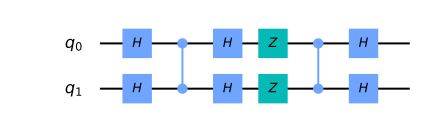

In [5]:
qiskit_grover_circ = QuantumCircuit(2)

# inicjalizacja
qiskit_grover_circ.h(0)
qiskit_grover_circ.h(1)

# wyrocznia;
# dla stanue specjalnego |11> wyrocznia to po prostu bramka CZ
qiskit_grover_circ.cz(0, 1)

# pomocniczny Hadamard
qiskit_grover_circ.h(0)
qiskit_grover_circ.h(1)

# inwersja
qiskit_grover_circ.z(0)
qiskit_grover_circ.z(1)
qiskit_grover_circ.cz(0, 1)

# pomocniczny Hadamard
qiskit_grover_circ.h(0)
qiskit_grover_circ.h(1)

qiskit_grover_circ.draw()

Dla N=4 wystarczy tylko jedna iteracja Grovera.

Uruchomienie na symulatorze:

In [8]:
backend_sim = Aer.get_backend('statevector_simulator')
job_sim = execute(qiskit_grover_circ, backend_sim)
statevec = job_sim.result().get_statevector()
vector2latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

Jak widac otrzymujemy poprawny stan końcowy reprezentujący szukaną wartość 11.

Uruchomienie na symulatorze QASM z histogramem daje podobny rezultat:

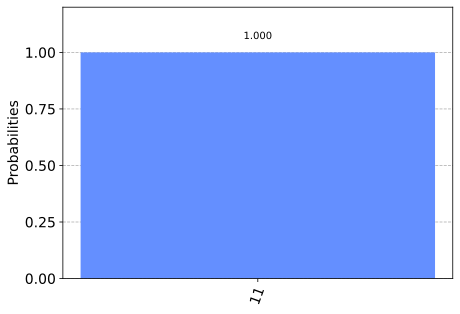

In [9]:
qiskit_grover_circ.measure_all()
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(qiskit_grover_circ, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

Teraz uruchomie układ na prawdziwym komputerze kwantowym.

In [10]:
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

Running on current least busy device:  ibmq_burlington


In [12]:
from qiskit.tools.monitor import job_monitor
job = execute(qiskit_grover_circ, backend=device, shots=1024, max_credits=10)
job_monitor(job, interval = 2)

Job Status: job has successfully run


Rysujemy histogram zmierzonych stanów końcowych - spodziewamy się wyraźnie najwięszkej liczby próbek do stanu 11 i małe wartości niezerowe w innych stanach.

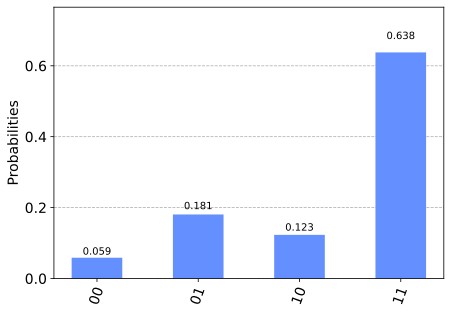

In [14]:
results = job.result()
answer = results.get_counts(qiskit_grover_circ)
plot_histogram(answer)

Jak widać wynik jest prawidłowy leczy prawdopodobieństwo uzyskane dla stanu specjalnego jest daleki od pożądanego.

Teraz zaprezentuje rozwiązanie "książkowe", które poznaliśmy na zajęciach:

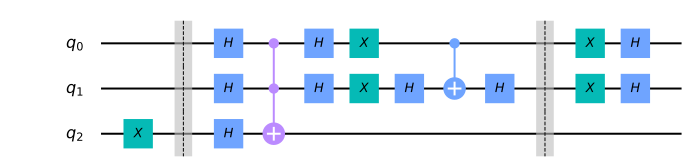

In [29]:
# tym razem potrzeba 3 qubitow w ukladzie
textbook_grover_circ = QuantumCircuit(3)

# ustawienie jedynki dla qubicie wyjsciowym
textbook_grover_circ.x(2)
textbook_grover_circ.barrier()

# inicjalizacja
textbook_grover_circ.h(0)
textbook_grover_circ.h(1)
textbook_grover_circ.h(2)

# wyroczna dla |11> to Toffoli
textbook_grover_circ.ccx(0, 1, 2)

# inwersja
textbook_grover_circ.h(0)
textbook_grover_circ.h(1)
textbook_grover_circ.x(0)
textbook_grover_circ.x(1)
textbook_grover_circ.h(1)
textbook_grover_circ.cx(0, 1)
textbook_grover_circ.h(1)
textbook_grover_circ.barrier()
textbook_grover_circ.x(0)
textbook_grover_circ.x(1)
textbook_grover_circ.h(0)
textbook_grover_circ.h(1)

textbook_grover_circ.draw()

In [30]:
backend_sim = Aer.get_backend('statevector_simulator')
job_sim = execute(textbook_grover_circ, backend_sim)
statevec = job_sim.result().get_statevector()
vector2latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

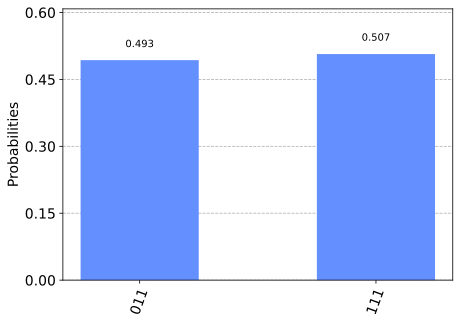

In [31]:
textbook_grover_circ.measure_all()
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(textbook_grover_circ, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [32]:
from qiskit.tools.monitor import job_monitor
job = execute(textbook_grover_circ, backend=device, shots=1024, max_credits=10)
job_monitor(job, interval = 2)

Job Status: job has successfully run


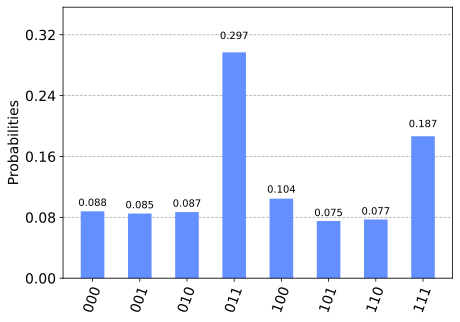

In [33]:
results = job.result()
answer = results.get_counts(textbook_grover_circ)
plot_histogram(answer)

W każdym z przykadków otrzymujemy maksima prawdpodobieństwa dla dwóch stanów końcowych: |110> oraz |111>. Ponieważ qubit wyjściowy nie jest dla nas istotny możemy go po prostu pominąć, otrzymując prawidłowy stan końcowy |11>.

Jeśli chodzi o różnice między rozwiązaniem książkowym a rozwiązaniem z optymalizacjami IBM to to drugie jest na pewno bardziej optymalne (używa mniejszej liczby bramek i mniejszej liczby qubitów, przez co akumulacja błędów związanych z dekoherencję jest mniejsza). Widać to wyraźnie w przypadku uruchamiania obu układów na prawdziym komputerze kwantowym: szum w postaci niezerowych prawdopodobieństw innych stanów niż pożądany był bardzo duży dla algorytmu książkowego, zaś w wersji IBM był on stosunkowo niewielki, więc odpowiedz była bardziej jednoznaczna. W przypadku uruchamiania układów na symulatorach jakość wyników jest zbliżona, gdyż symulator statevector jest idealny (tj. nie wprowadza żadnych i nie jest stochastyczny), zaś symulator QASM (w wersji domyślnej, bez NoiseModelu), również jest idealny, tylko, że wprowadza element niepowności związanej z samym pomiarem.

Zadanie 2: Należało zademonstrować na wybranym symulatorze pokazującym aplitudy działanie algorytmu Grovera dla wybranego n>2. Ja wybrałem wersji z dostarczonego notebooka, która dostosowana jest dla n=3. Warto pamiętać, że implementacja to zawiera modyfikację, w której mamy więcej niż jeden stan specjalny (w tym przypadku są to stany 101 i 110), przez co ilość iteracji wymaganej do znalezienia jednego z wyników jest mniejsza niż w wariancie orginalnym.

In [68]:
# Definiujemy wyrocznie, która ma za zadanie odpowiedzieć TAK dla stanów 101 i 110, a NIE w każdym
# pozostałym wypadku. Układ spełniający takie wymogi składać się może z dwóch bramek kontrolowanych Z.
def phase_oracle(circuit):
    circuit.cz(0, 2)
    circuit.cz(1, 2)

In [69]:
# Tutaj definiujemy inwersję. Podobnie jak w wersji książkowej dla n=2 tutaj również stostujemy podwuje
# "obłożenie" bramki faktycznie odpowiedzialnej za główny krok inwersji bramkami H i X. Stostujemy również
# pomocnicze bramki Hadamarda, które razem z bramką podwójnie kontrolwanego Z tworzą "serce" inwersji.
def diffuser(circuit):
    qubits = circuit.qubits
    nqubits = len(qubits)
    
    for q in range(nqubits):
        circuit.h(q)
        circuit.x(q)
    
    # Do controlled-Z
    circuit.h(2)
    circuit.ccx(0,1,2)
    circuit.h(2)
    
    for q in range(nqubits):
        circuit.x(q)
        circuit.h(q)

In [70]:
# Definiujemy ilość qubitów w układzie, co z kolei wymusza konkretny zakres możliwych stanów specjalnych
# które będziemy wyszukiwać.
n = 3
barriers = True

# Tworzymym obiekt układu.
grover_circuit = QuantumCircuit(n)

# Sklejamy w jeden model warstwy:

# Inicjalizacja
for qubit in range(n):
    grover_circuit.h(qubit)
# W tym momecie wszystkie qubity sa w stanie superpozycji jednorodnej

if barriers:
    grover_circuit.barrier()
    
grover_circuit.snapshot("init")

# Wyrocznia
phase_oracle(grover_circuit)
# W tym momencie wyrocznie zaznaczy nam poszukiwane stany mnożąc je przez -1

if barriers:
    grover_circuit.barrier()
    
grover_circuit.snapshot("oracle")

# Inwersja
diffuser(grover_circuit)
# W tym momecie powinny pozostać tylko stany poszukiwane

grover_circuit.snapshot("inversion")

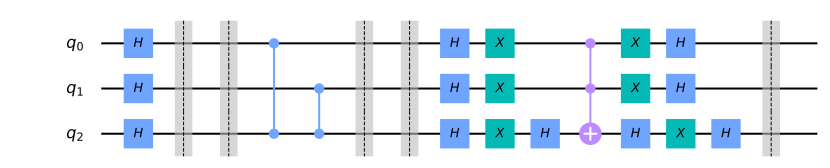

In [71]:
grover_circuit.draw(output="mpl")

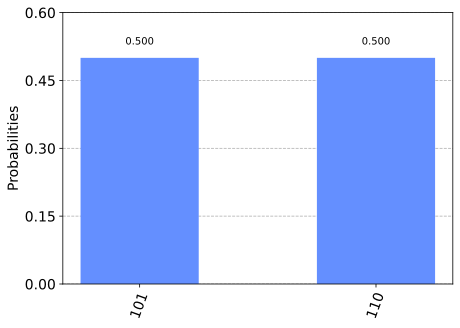

In [72]:
backend = Aer.get_backend('statevector_simulator')
shots = 1024
results = execute(grover_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [73]:
# Zdefiniowanie w układzie snapshotów bezpośrednio po aplikowaniu wyroczni oraz inwersji pozwala
# teraz sprawdzić jakie były w tych stanach amplitudy (a właściwie wektory stanu)
snapshots = results.data()['snapshots']['statevector']

In [79]:
# po inicjalizacji Hadamardami
vector2latex(snapshots["init"][0], pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

In [80]:
# Po aplikowaniu wyroczni
vector2latex(snapshots["oracle"][0], pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

In [81]:
# Po aplikowaniu inwersji
vector2latex(snapshots["inversion"][0], pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

Jak widać wartości amplitud pokrywają się z oczekiwaniami, wyrocznia przemnać poszukiwane stany 101 i 110 przez -1, zaś inwersja zeruje wszystkie stany poza tylko, których szukamy,

Jak widać układ poprawnie znajduje stan poszukiwane. Warto zaznaczyć, że normalnie dla n=3 wzór na ilość wymaganych iteracji (PI/4 * sqrt(2^n)) dawałby wynik w przybliżeniu równy 2.22, czyli konieczne byłyby dwie iteracje Grovera, jednak ponieważ w tym przypadku mamy dwa stany specjalne ilość wymaganych iteracji jest o połowe mniejsza - czyli wystarcza tylko jedna iteracja.

Dla kompletności uruchamiam również układ na prawdziwym komputerze kwantowym:

In [52]:
# Pomiar końcowy
grover_circuit.measure_all()

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_london


In [53]:
shots = 1024
job = execute(grover_circuit, backend=backend, shots=shots, optimization_level=3)

job_monitor(job, interval = 2)

Job Status: job has successfully run


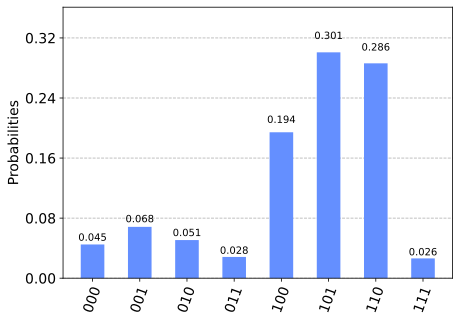

In [54]:
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)